In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data = "/kaggle/input/audio-dataset/Audio"

In [3]:
def get_wav_info(file_path):
    try:
        sampling_rate, data = wavfile.read(file_path)
        duration = len(data) / sampling_rate
        return {"file_path": file_path, "sampling_rate": sampling_rate, "duration": duration}
    except Exception as e:
        return {"file_path": file_path, "error": str(e)}

In [4]:
wav_files = [f for f in os.listdir(data) if f.endswith('.wav')]

db = [get_wav_info(os.path.join(data, wav_file)) for wav_file in wav_files]

df = pd.DataFrame(db)

print(df)

                                            file_path  sampling_rate  \
0   /kaggle/input/audio-dataset/Audio/BACKGROUND_0...          44100   
1     /kaggle/input/audio-dataset/Audio/DRONE_030.wav          44100   
2     /kaggle/input/audio-dataset/Audio/DRONE_028.wav          44100   
3   /kaggle/input/audio-dataset/Audio/HELICOPTER_0...          44100   
4     /kaggle/input/audio-dataset/Audio/DRONE_008.wav          44100   
..                                                ...            ...   
85  /kaggle/input/audio-dataset/Audio/HELICOPTER_0...          44100   
86  /kaggle/input/audio-dataset/Audio/HELICOPTER_0...          44100   
87  /kaggle/input/audio-dataset/Audio/HELICOPTER_0...          44100   
88  /kaggle/input/audio-dataset/Audio/HELICOPTER_0...          44100   
89    /kaggle/input/audio-dataset/Audio/DRONE_011.wav          44100   

     duration  
0   10.000023  
1   10.000045  
2   10.000045  
3   10.000045  
4   10.000023  
..        ...  
85  10.000023  
86  10.

In [5]:
df.sample(5)

,file_path,sampling_rate,duration
87,/kaggle/input/audio-dataset/Audio/HELICOPTER_0...,44100,10.000045
78,/kaggle/input/audio-dataset/Audio/BACKGROUND_0...,44100,10.000023
22,/kaggle/input/audio-dataset/Audio/BACKGROUND_0...,44100,10.000045
69,/kaggle/input/audio-dataset/Audio/DRONE_014.wav,44100,10.000045
35,/kaggle/input/audio-dataset/Audio/BACKGROUND_0...,44100,10.000023


In [6]:
df['label'] = df['file_path'].str.extract(r'/([A-Z]+)_\d+\.wav$')

df.head(5)

,file_path,sampling_rate,duration,label
0,/kaggle/input/audio-dataset/Audio/BACKGROUND_0...,44100,10.000023,BACKGROUND
1,/kaggle/input/audio-dataset/Audio/DRONE_030.wav,44100,10.000045,DRONE
2,/kaggle/input/audio-dataset/Audio/DRONE_028.wav,44100,10.000045,DRONE
3,/kaggle/input/audio-dataset/Audio/HELICOPTER_0...,44100,10.000045,HELICOPTER
4,/kaggle/input/audio-dataset/Audio/DRONE_008.wav,44100,10.000023,DRONE


In [ ]:
for ind, row in df.iterrows():
    audio_file_path = row['file_path']

    # Load the audio file
    audio_data, sr = librosa.load(audio_file_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(f"Waveform - {os.path.basename(audio_file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

In [ ]:
def plot_spectrogram(audio_file_path):
    # Load the audio file
    audio_data, sr = librosa.load(audio_file_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT)
    D = np.abs(librosa.stft(audio_data))

    # Convert to decibels (log scale)
    DB = librosa.amplitude_to_db(D, ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram - {os.path.basename(audio_file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()



In [ ]:
# Iterate over the dataframe, load each audio file, and plot the spectrogram
for ind, row in df.iterrows():
    audio_file_path = row['file_path']
    plot_spectrogram(audio_file_path)

In [8]:
averages = df.groupby('label')[['sampling_rate', 'duration']].mean().reset_index()

print(averages)


        label  sampling_rate   duration
0  BACKGROUND        44100.0  10.000032
1       DRONE        44100.0  10.000036
2  HELICOPTER        44100.0  10.000036


In [9]:
# Map labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_numeric'] = df['label'].map(label_mapping)

print("Label Mapping:", label_mapping)

Label Mapping: {'BACKGROUND': 0, 'DRONE': 1, 'HELICOPTER': 2}


In [10]:
def extract_features(row, n_mfcc=13):
    try:
        # Load the audio file (resampled already, if needed)
        y, sr = librosa.load(row['file_path'], sr=None)  # Use original sampling rate
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        row['mfcc_mean'] = mfccs.mean(axis=1) 
        row['mfcc_var'] = mfccs.var(axis=1) 
        row['chroma_mean'] = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
        row['spectral_centroid_mean'] = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    except Exception as e:
        row['error'] = str(e)
    return row

df = df.apply(extract_features, axis=1)

In [11]:
df.head()

,file_path,sampling_rate,duration,label,label_numeric,mfcc_mean,mfcc_var,chroma_mean,spectral_centroid_mean
0,/kaggle/input/audio-dataset/Audio/BACKGROUND_0...,44100,10.000023,BACKGROUND,0,"[-460.4573, 153.70146, -31.98041, 72.77393, -7...","[195.40103, 73.79969, 134.82362, 68.47127, 70....","[0.64871824, 0.5993003, 0.6068058, 0.57842106,...",2818.854619
1,/kaggle/input/audio-dataset/Audio/DRONE_030.wav,44100,10.000045,DRONE,1,"[-295.34653, 67.18624, -0.3509278, 46.90171, 0...","[2014.114, 284.17157, 215.69394, 174.11827, 10...","[0.64124113, 0.6630774, 0.6895677, 0.6653638, ...",5439.641780
2,/kaggle/input/audio-dataset/Audio/DRONE_028.wav,44100,10.000045,DRONE,1,"[-303.42038, 58.81463, -12.903596, 32.53272, -...","[3384.2698, 260.2587, 130.48785, 92.494995, 41...","[0.7149131, 0.6894931, 0.6397704, 0.6273354, 0...",6271.102144
3,/kaggle/input/audio-dataset/Audio/HELICOPTER_0...,44100,10.000045,HELICOPTER,2,"[-67.579254, 130.77907, -25.273895, 34.02284, ...","[682.9582, 134.28558, 59.51499, 28.414171, 22....","[0.5710717, 0.6427144, 0.69375473, 0.6342499, ...",3348.542945
4,/kaggle/input/audio-dataset/Audio/DRONE_008.wav,44100,10.000023,DRONE,1,"[-441.16455, 85.27817, -28.923977, 15.386227, ...","[6411.129, 1528.1613, 130.44467, 119.37335, 11...","[0.4167115, 0.35947347, 0.3655914, 0.40768206,...",4998.928703


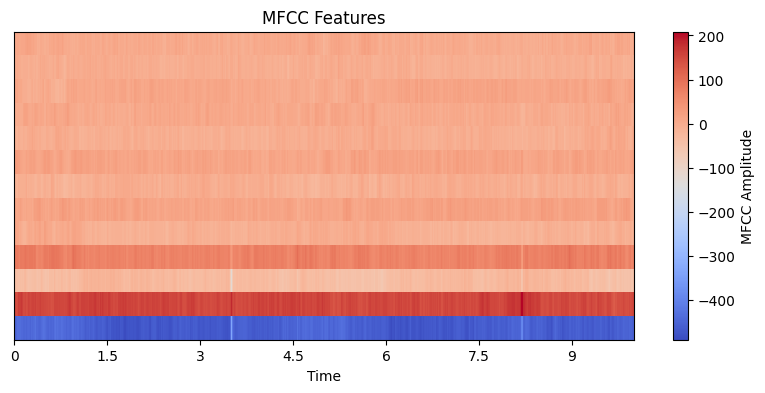

In [12]:
y, sr = librosa.load(df['file_path'][0], sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(label='MFCC Amplitude')
plt.title('MFCC Features')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Separate features and labels
X = np.vstack(df['mfcc_mean'].values)  # Stack MFCC features into a matrix
y = df['label_numeric'].values         # Numerical labels

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels (if not already numerical)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'GaussianNB': GaussianNB(),
    'KMeans': KMeans(n_clusters=len(np.unique(y))),  # Use number of classes for clustering
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'MLP': MLPClassifier(max_iter=500)
}


In [15]:
from sklearn.metrics import classification_report

# Results dictionary to store metrics
results = {model_name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for model_name in models.keys()}

# K-fold cross-validation
for model_name, model in models.items():
    print(f"Training {model_name}...")
    for train_index, test_index in kf.split(X):
        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train model
        if model_name == 'KMeans':
            model.fit(X_train)  # KMeans doesn't use labels for training
            y_pred = model.predict(X_test)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Compute metrics
        results[model_name]['accuracy'].append(accuracy_score(y_test, y_pred))
        results[model_name]['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        results[model_name]['recall'].append(recall_score(y_test, y_pred, average='weighted'))
        results[model_name]['f1'].append(f1_score(y_test, y_pred, average='weighted'))

# Average metrics over all folds
final_results = {model_name: {metric: np.mean(scores) for metric, scores in metrics.items()} 
                 for model_name, metrics in results.items()}


Training Logistic Regression...
Training Random Forest...
Training SVM...
Training GaussianNB...
Training KMeans...
Training XGBoost...


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Training MLP...


In [16]:
# Print results
print("Model Performance Metrics:")
for model_name, metrics in final_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")


Model Performance Metrics:

Logistic Regression:
  Accuracy: 0.8222
  Precision: 0.8654
  Recall: 0.8222
  F1: 0.8218

Random Forest:
  Accuracy: 0.7889
  Precision: 0.8248
  Recall: 0.7889
  F1: 0.7824

SVM:
  Accuracy: 0.8667
  Precision: 0.8851
  Recall: 0.8667
  F1: 0.8639

GaussianNB:
  Accuracy: 0.7000
  Precision: 0.7518
  Recall: 0.7000
  F1: 0.6835

KMeans:
  Accuracy: 0.1667
  Precision: 0.1721
  Recall: 0.1667
  F1: 0.1560

XGBoost:
  Accuracy: 0.8000
  Precision: 0.8368
  Recall: 0.8000
  F1: 0.7995

MLP:
  Accuracy: 0.9111
  Precision: 0.9322
  Recall: 0.9111
  F1: 0.9102
